# Introduction
Generally unsupervised machine learning techniques are used to work with unlabeled data. For exploratory purposes, we are going to use these techniques with labeled data. Farther down, we will use the simplistic, albeit, effective K-Means clustering method in conjunction with supervised machine learning techniques in order to print out confusion matrices to output information about how effective our predictions were.

In [413]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

In [471]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels

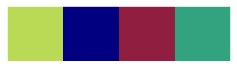

In [415]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# set style of plots
sns.set_style('dark')

#define a custom palette
customPalette = ['#bada55', '#000080', '#901e40', '#33a27f']
sns.set_palette(customPalette)
sns.palplot(customPalette)

# Import Spotify data
We extracted thousands of songs using Spotipy, a library that leverages the Spotify API, to inspect song features and artist data for the vast database of songs that Spotify houses. Now, let's import that data and explore it.

In [495]:
songs = pd.read_csv("deduplicated_tracks_from_my_playlists.csv", encoding = "latin-1")

After importing the data, be sure to confirm that the import was successful by looking at the dataframe overview (info) and top 5 rows of observations (head).

In [496]:
songs.info()
songs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935 entries, 0 to 2934
Data columns (total 18 columns):
added_at            2935 non-null object
name                2935 non-null object
artist              2935 non-null object
id                  2935 non-null object
popularity          2935 non-null int64
danceability        2935 non-null float64
energy              2935 non-null float64
loudness            2935 non-null float64
speechiness         2935 non-null float64
acousticness        2935 non-null float64
tempo               2935 non-null float64
liveness            2935 non-null float64
valence             2935 non-null float64
instrumentalness    2935 non-null float64
key                 2935 non-null int64
time_signature      2935 non-null int64
mode                2935 non-null int64
duration_ms         2935 non-null int64
dtypes: float64(9), int64(5), object(4)
memory usage: 412.9+ KB


,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
0,2019-10-23T17:09:03Z,Kiss on My List,Daryl Hall & John Oates,7cDzJyC95jtGO9zAeZsWOg,61,0.815,0.741,-9.478,0.0310,0.434000,121.221,0.0689,0.965,0.111000,0,4,1,264987
1,2019-10-23T17:09:03Z,Wobbly,Ezra Furman,7qtT2n3ObzKG9as4fQhHZq,33,0.792,0.821,-5.397,0.0375,0.248000,133.030,0.3100,0.797,0.000000,0,4,1,180000
2,2019-10-23T17:09:03Z,Donât Fuck With My Money,Penguin Prison,0M3cwGSJwd84OmSgHcsP6r,35,0.757,0.819,-5.484,0.0663,0.114000,110.025,0.1270,0.923,0.000033,2,4,1,251276
3,2019-10-23T17:09:03Z,She's so High,Tal Bachman,7mnGQesk1TzQLzQ9bYWZPR,70,0.537,0.840,-4.626,0.0363,0.200000,124.269,0.0998,0.211,0.000002,9,4,1,224693
4,2019-10-23T17:09:03Z,Misery,Soul Asylum,1uGht4m9AVY641N2DzoPpi,39,0.380,0.643,-8.304,0.0287,0.000049,113.674,0.2440,0.297,0.000027,0,4,1,264360


We can use describe() to output statistics about the numerical information contained within the dataframe

In [418]:
songs.describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
count,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2.935000e+03
mean,36.097785,0.595299,0.614913,-8.307331,0.073672,0.269362,119.072194,0.180552,0.476685,0.127830,5.201704,3.926405,0.622828,2.477326e+05
std,22.907589,0.162723,0.214273,3.890095,0.082902,0.298251,27.225043,0.149723,0.245875,0.262676,3.582725,0.359932,0.484761,8.590056e+04
min,0.000000,0.000000,0.000076,-37.264000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.480000e+03
25%,16.000000,0.492000,0.474000,-9.845500,0.034400,0.025550,99.938000,0.093900,0.278500,0.000004,2.000000,4.000000,0.000000,2.005330e+05
50%,40.000000,0.611000,0.640000,-7.513000,0.043800,0.135000,117.792000,0.121000,0.473000,0.000649,5.000000,4.000000,1.000000,2.325420e+05
75%,54.000000,0.711000,0.782000,-5.737000,0.072200,0.463500,133.971000,0.218000,0.672000,0.062400,8.000000,4.000000,1.000000,2.761265e+05
max,91.000000,0.975000,0.998000,1.342000,0.958000,0.996000,216.101000,0.974000,1.000000,0.992000,11.000000,5.000000,1.000000,1.395733e+06


# Preprocessing and scaling
Before continuing with our exploration, let's normalize any data that isn't already measured between a value of 0 and 1 by using scikit learn's preprocessing methods:<br>
- The loudness feature is from -60db to 0 so we will normalise this column between 0 and 1.
- The tempo feature is in BPM so we will scale between 0 and 1 as well.

In [419]:
scaler = preprocessing.MinMaxScaler(feature_range=[0, 1])

loudness = songs[['loudness']].values
loudness_scaled = scaler.fit_transform(loudness)
songs['loudness'] = pd.DataFrame(loudness_scaled)

tempo = songs[['tempo']].values
tempo_scaled = scaler.fit_transform(tempo)
songs['tempo'] = pd.DataFrame(tempo_scaled)

Be sure to check that the loudness and tempo are scaled (we'll trust sklearn that the values are scaled correctly)

In [420]:
songs.describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
count,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2.935000e+03
mean,36.097785,0.595299,0.614913,0.750056,0.073672,0.269362,0.551003,0.180552,0.476685,0.127830,5.201704,3.926405,0.622828,2.477326e+05
std,22.907589,0.162723,0.214273,0.100764,0.082902,0.298251,0.125983,0.149723,0.245875,0.262676,3.582725,0.359932,0.484761,8.590056e+04
min,0.000000,0.000000,0.000076,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.480000e+03
25%,16.000000,0.492000,0.474000,0.710213,0.034400,0.025550,0.462460,0.093900,0.278500,0.000004,2.000000,4.000000,0.000000,2.005330e+05
50%,40.000000,0.611000,0.640000,0.770632,0.043800,0.135000,0.545078,0.121000,0.473000,0.000649,5.000000,4.000000,1.000000,2.325420e+05
75%,54.000000,0.711000,0.782000,0.816635,0.072200,0.463500,0.619946,0.218000,0.672000,0.062400,8.000000,4.000000,1.000000,2.761265e+05
max,91.000000,0.975000,0.998000,1.000000,0.958000,0.996000,1.000000,0.974000,1.000000,0.992000,11.000000,5.000000,1.000000,1.395733e+06


# Histogram
Move over Instagram, it's histogram time!<br>
Histograms (different from bar charts) grant us an incredible overview of our song selection. We can see at a high level song features that are contained in this song dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9516B2208>,
      dtype=object)

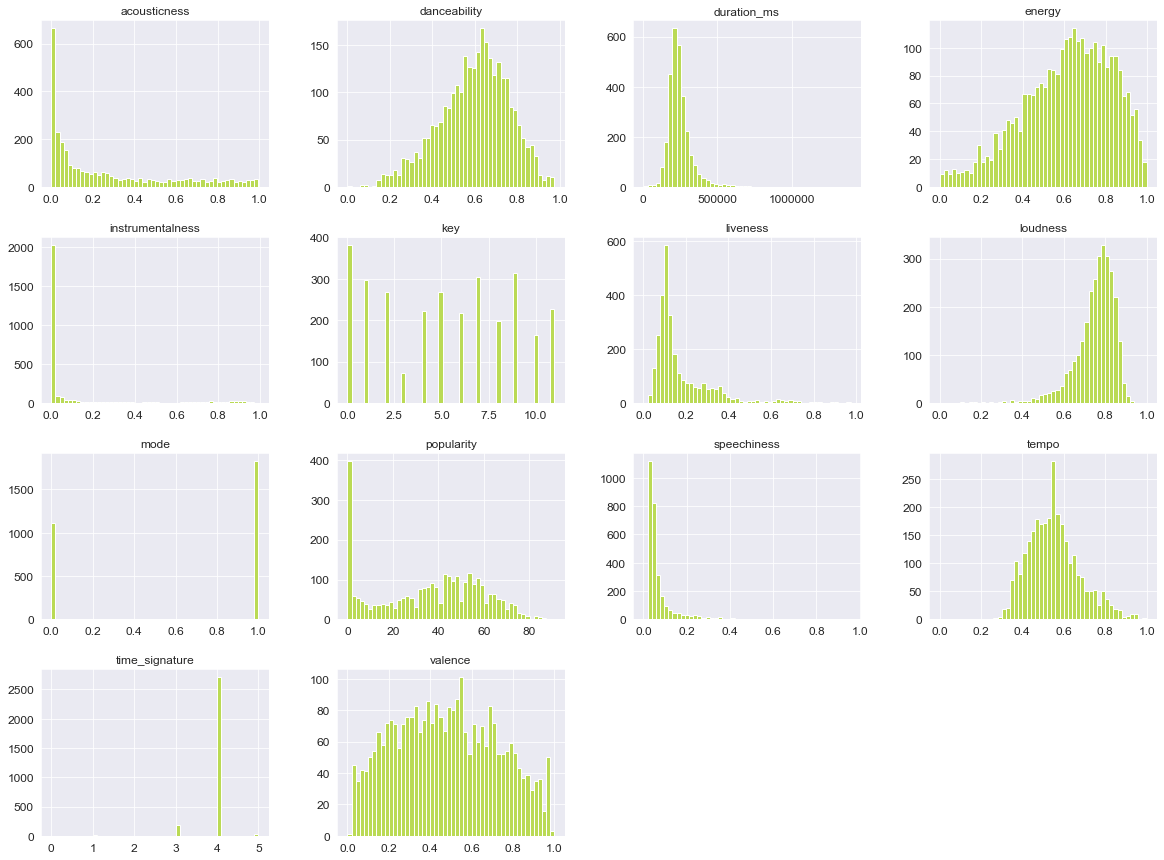

In [421]:
songs.hist(bins=50,figsize=(20,15))

From the above histogram we can extract the following observations about our dataset:<br>
- **acousticnes**: most of the songs are low on acousticness
- **danceability**: we could probably dance to many of these songs
- **duration_ms**: thankfully, all of the songs are mostly the same length. Wouldn't want our music to last forever now would we?
- **energy**: many of the songs are highly energetic, this makes sense, I don't know many people who enjoy constant slow, droning music. Me included.
- **instrumentalness**: this is strange, most of the songs are low on "instrumentalness", we'll dig into Spotify's definition of this term for further insight as we proceed into our exploration
- **key**: interesting, we have a nice mix of "keys" in our song selection
- **liveness**: this makes sense, I don't listen to a lot of live music, so the majority of the songs range in more-than-likely "studio setting" value levels
- **loudness**: I don't particularly like loud music, so I am not sure how to interpret this. We'll reference Spotify's definition of "loudness" for additional insight
- **mode**: there are only two modes, and we can see that I like more songs with a higher mode
- **popularity**: eesh, apparently my song taste drift towards the less popular songs
- **speechiness**: good to know, most of the songs I like are sung, not said
- **tempo**: most of the songs I like have an average tempo
- **time_signature**: I am no music expert, but 4:4 time signature is the most widely used time signature
- **valence**: how "positive" a song sounds. The word "valence" also has something to do with electrons so that intrigues me. Anyway, this is all over the map. Interesting!

Now let's copy our song dataset, and keep only the Spotify song features. One could argue that we should include features such as **'key'** and **'time_signature'** but I'd like to only explore the Spotify specific song features and exclude song features that are 'sonically' standard. We'll also remove **'popularity'**. Recall above that I like less popular music. I don't want this to influence my clusters.

In [422]:
songs_features = songs.copy()
songs_features = songs_features.drop(['added_at', 
                                      'name', 
                                      'artist', 
                                      'id', 
                                      'key', 
                                      'time_signature', 
                                      'mode', 
                                      'popularity', 
                                      'duration_ms'], axis = 1)

songs_features.head()

,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness
0,0.815,0.741,0.719733,0.0310,0.434000,0.560946,0.0689,0.965,0.111000
1,0.792,0.821,0.825442,0.0375,0.248000,0.615592,0.3100,0.797,0.000000
2,0.757,0.819,0.823188,0.0663,0.114000,0.509137,0.1270,0.923,0.000033
3,0.537,0.840,0.845413,0.0363,0.200000,0.575051,0.0998,0.211,0.000002
4,0.380,0.643,0.750142,0.0287,0.000049,0.526023,0.2440,0.297,0.000027


# Exploratory Data Analysis (EDA)
Now that pre-processing is complete, let's explore the data! We'll start with a very straight forward Principal Component Analysis to choose a target number of clusters to use for the various unsupervised algorithms that exist.<br>

## Principal Component Analysis (PCA)
Principal Component Analysis is a re-occurring theme in unsupervised learning. PCA acts as a sort of pre-cursor for several other unsupervised learning techniques. We'll use it independently below and as a pre-requisite for other techniques.<br>
For the initial PCA, I used this tutorial to output this plot:<br>
https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe<br>
We will not pass any parameters into PCA() for this use of the function. The plot, therefore, will output the default number of components (9). I cannot input an n_components value greater than 9 because I only have 9 components to reduce.<br>
Additional information on parameters for PCA() can be found here:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

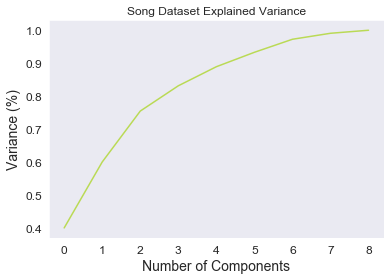

In [423]:
pca = PCA().fit(songs_features)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Song Dataset Explained Variance')
plt.show()

In [424]:
print(pca.explained_variance_ratio_.cumsum())

[0.39932415 0.59967949 0.75436563 0.83120386 0.88916656 0.93298422
 0.97259189 0.99078208 1.        ]


The explained variance describes how much information (variance) can be attributed to each of the principal components. By looking at the cumulative sum of explained_variance_ratio_, we can see that 6 clusters will explain 97% of the variation that exists in our song data. We will update our pca variable to account for these six clusters and then output the relationships between the song features for each component.

In [425]:
pca = PCA(n_components = 6).fit(songs_features)
print (pd.DataFrame(pca.components_, columns=songs_features.columns, index = ['PC-1','PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6']))

      danceability    energy  loudness  speechiness  acousticness     tempo  \
PC-1     -0.170652 -0.484120 -0.194263    -0.013453      0.717060 -0.064292   
PC-2     -0.098799  0.122098 -0.033158    -0.044419     -0.312937  0.043689   
PC-3      0.324757 -0.077028 -0.079201     0.024510      0.318741 -0.033510   
PC-4     -0.499503  0.438314  0.102697     0.025746      0.334515  0.183390   
PC-5      0.443984 -0.228758 -0.060628     0.129167     -0.123406 -0.378746   
PC-6     -0.375861 -0.605415 -0.294656    -0.022851     -0.376122  0.384425   

      liveness   valence  instrumentalness  
PC-1 -0.046977 -0.375813          0.191926  
PC-2  0.004123 -0.237442          0.903341  
PC-3 -0.059242  0.800526          0.366955  
PC-4  0.612843  0.157202          0.036698  
PC-5  0.743856 -0.133261          0.020749  
PC-6  0.201128  0.269511         -0.050184  


## Elbow Method for Optimal k
Now let's use the Elbow Method to find an optimal cluster number. We'll set a range between 1 and 15. I suspect that we won't need more than 10 clusters, but it will be interesting to see the curve that develops.<br>
<br>
For more information about the elbow method, see: https://bl.ocks.org/rpgove/0060ff3b656618e9136b

In [426]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(songs_features)
    sum_of_squared_distances.append(km.inertia_)

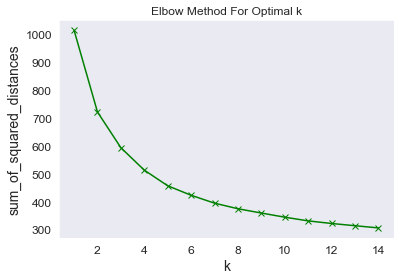

In [427]:
plt.plot(K, sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow method returned what almost looks like the inverse of the Explained Variance plot seen above! The plot begins to flatten out significantly after k = 6. This infers that 6 is a good number of clusters to illustrate for this dataset.

# Silhouette Score
I am calculating the silhouette score because I am interested to see how many of my clusters will overlap. As long as I don't receive a negative number, I will be satisfied. I won't be too alarmed if the number is close to 0. I know that I like similar types of songs so I anticipate that there may be some clusters that overlap.<br>

Some information directly from sklearn that describes what the silhouette score is: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html<br>
- The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
- The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.
- Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.<br>
- The best value is 1 and the worst value is -1.
- Values near 0 indicate overlapping clusters.
- Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.<br>

In [428]:
for n_clusters in range(1, 7):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(songs_features)
    centers = clusterer.cluster_centers_
    # print('cluster:', clusterer)
    # print('preds:', preds)
    # print('centers:', centers)

In [429]:
score = silhouette_score(songs_features, preds, metric='euclidean')
print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 6, silhouette score is 0.21664674327765915)


# K-Means Clustering

The idea of K-Means clustering befuddled me for longer than it should have. However, I found a nice tutorial that boiled an explanation down to two bulletpoints. If the author is accurate, then from now on I will look really smart when I explain data to people.<br>

Citation: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html<br>
K-Means stands as a sort of foundation when using unsupervised learning algorithms. From the above site, there are two principal components (see what I did there) that a data engineer needs to keep in mind:
- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

In [430]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit(songs_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

We're using PCA here because we want a simple 2D representation. For this exploration, I find very little benefit to using a 3D model other than that it will look "cooler". Note that "n_components" will be equal to "2". We'll use the first two Principal Components here as the first principal components are generall the most accurate.

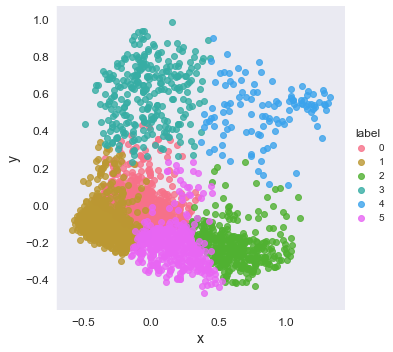

In [431]:
y_kmeans = kmeans.predict(songs_features)
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(songs_features)

pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

cluster = sns.lmplot(data = pc, x = 'x', y = 'y', hue = 'label', 
                   fit_reg = False, legend = True, legend_out=True)

# T-Distributed Stochastic Neighbor Embedding (T-DSNE)
T-Distributed Stochastic Neighbor Embedding aka T-DSNE is another technique for clustering data. T-DSNE is computationally intensive to use on high dimensional datasets, mostly because it is based more on probability and less on mathematics. It is generally good to reduce the number of dimensions before executing a T-DSNE regression<br>
Source:<br>
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

- We're going to leverage the y_kmeans object that we declared above in order to perform the "pre-dimensional reduction" before running *this* dimensional reduction.
- We will again represent our data in 2D (note the re-appearance of n_components)
- We could probably increase the dimensional representation, but we won't because we want to keep our exploration simple.

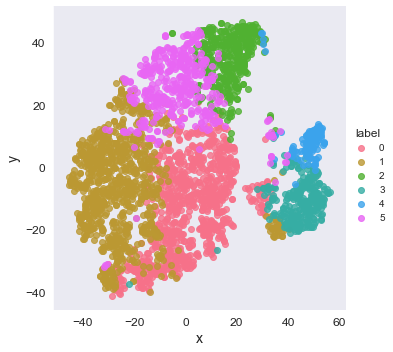

In [432]:
tsne = TSNE(n_components = 2, perplexity = 50)

tsne_components = tsne.fit_transform(songs_features)

ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

## Hierarchical Clustering

From: https://builtin.com/data-science/unsupervised-learning-python<br>

"As its name implies, hierarchical clustering is an algorithm that builds a hierarchy of clusters. This algorithm begins with all the data assigned to a cluster, then the two closest clusters are joined into the same cluster. The algorithm ends when only a single cluster is left."

In [521]:
songs_hc = songs.copy()
songs_hc = songs_hc.drop(['added_at', 
                          'name', 
                          'artist', 
                          'id'], axis = 1)

songs_hc.head()

,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
0,61,0.815,0.741,-9.478,0.0310,0.434000,121.221,0.0689,0.965,0.111000,0,4,1,264987
1,33,0.792,0.821,-5.397,0.0375,0.248000,133.030,0.3100,0.797,0.000000,0,4,1,180000
2,35,0.757,0.819,-5.484,0.0663,0.114000,110.025,0.1270,0.923,0.000033,2,4,1,251276
3,70,0.537,0.840,-4.626,0.0363,0.200000,124.269,0.0998,0.211,0.000002,9,4,1,224693
4,39,0.380,0.643,-8.304,0.0287,0.000049,113.674,0.2440,0.297,0.000027,0,4,1,264360


We will extract measurements as a NumPy array and perform hierarchical clustering on samples using the
linkage() function with the method='complete' keyword argument. Afterwards, we will plot a dendrogram using the dendrogram() function on mergings, specifying the keyword arguments labels=varieties, leaf_rotation=90, and leaf_font_size=6.

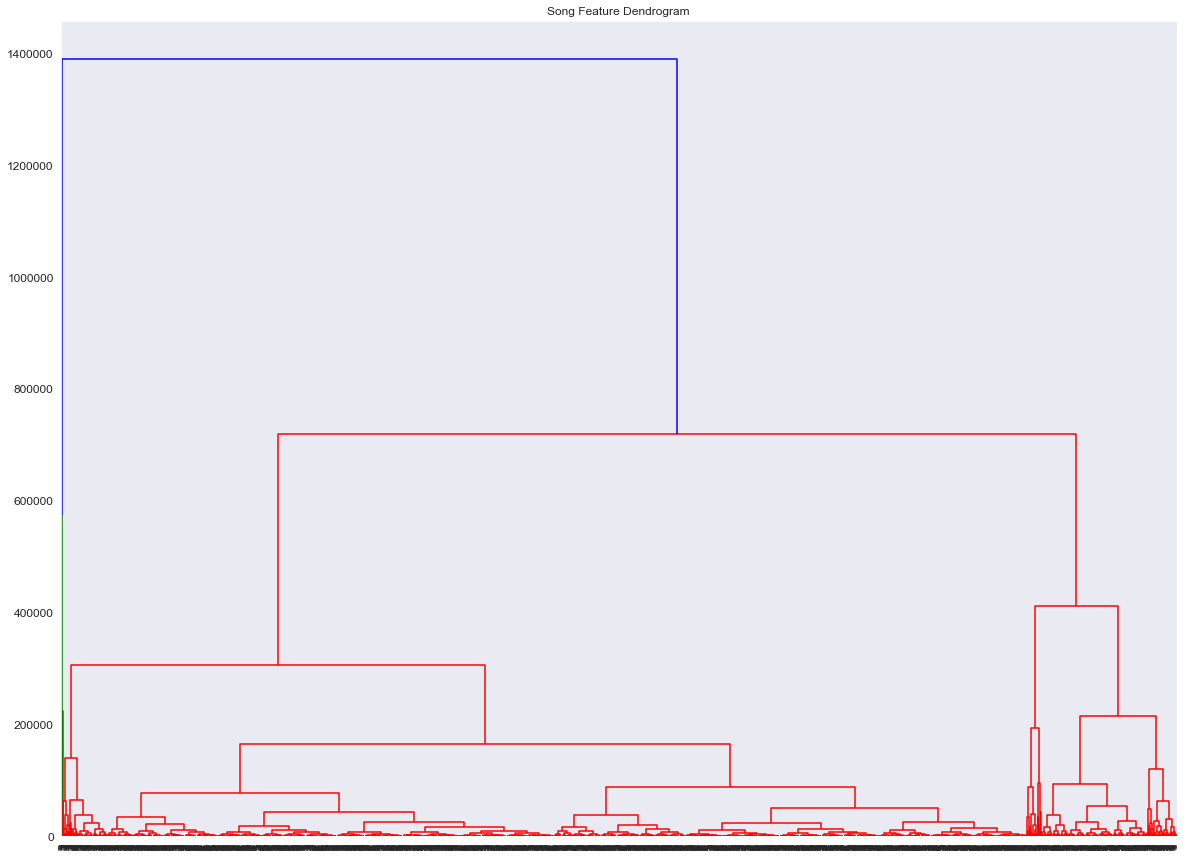

In [522]:
varieties = list(songs_hc.pop('popularity'))

# Extract the measurements as a NumPy array
samples = songs_hc.values

mergings = linkage(samples, method='complete')

plt.figure(figsize=(20, 15))
plt.title("Song Feature Dendrogram")
dendrogram(mergings,
           labels = varieties,
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

Using hierarchical clustering, we can determine, that out of two large groups, descend multiple other groups.

# Density-based spatial clustering (DBSCAN)
We can also cluster using DBSCAN. Also known as density-based spatial clustering, a user does not need to explicitly input a number of clusters when leveraging this clustering algorithm. However, in sklearn, there are two parameters that should be used to tune the output:<br>
- **'eps'** is the 'maximum distance between two data points to be considered in the same neighborhood'
- **'min_samples'** is the 'minimum amount of data points in a neighborhood to be considered a cluster.'

They both have defaults but since datasets vary, it's important to tune them based on your specific dataset.<br>

I chose to use '0.3' and '10' respectively as these are the values that are seen in an example from:<br>
https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

Even though an explicit cluster number is not needed for this method, I set one anyway when declaring my 'pca' variable for this method. Below, we can see the index of PCA-related values that are printed with this option set.<br>


I ended up using the following tutorial in order to graph a representation of what this looks like.<br>
With some assistance from: https://builtin.com/data-science/unsupervised-learning-python

In [433]:
# Declaring Model
dbscan = DBSCAN(eps=0.3, min_samples=10)

# Fitting
dbscan.fit(songs_features)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

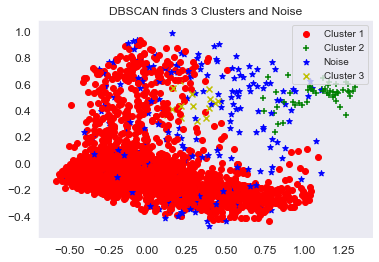

In [434]:
# Transforming Using PCA
pca = PCA().fit(songs_features)
pca_2d = pca.transform(songs_features)

# Plot based on Class
for i in range(0, pca_2d.shape[0]):
    # print(dbscan.labels_[i])
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='o')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='+')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
    elif dbscan.labels_[i] == 2:
        c4 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='y', marker='x')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Noise', 'Cluster 3'])
plt.title('DBSCAN finds 3 Clusters and Noise')
plt.show()

## Now let's explore the clusters and see what songs they contain
After our dimensionality reduction, and having experimented with a couple of different clustering methods, we can continue our exploration using the K-Means clustering method invoked a bit earlier. The reason we use K-Means is due to the fact that PCA, T-DSNE, and DBSCAN obfuscate the data into new datasets. This is convenient for clustering, but it becomes difficult to view the original data post-cluster.<br>
This is an important point to make, because later on when we use supervised machine learning techniques, we end up using K-Means over other unsupervised models. We can "get away with this" because our data is labeled - very clearly I might add. K-Means is a very simplistic technique and retains most of the original data.

In [435]:
songs['label'] = y_kmeans

# shuffle dataset

songs = songs.sample(frac=1)
songs['label'].value_counts()

1    881
0    879
5    413
2    366
3    281
4    115
Name: label, dtype: int64

In [436]:
songs[songs['label'] == 0].head(40)

,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
2817,2013-11-09T23:10:32Z,Fall In Love,Phantogram,73FCPll1CK0sklAt1VlmFc,0,0.328,0.860,0.882402,0.1200,0.047700,0.869168,0.2120,0.2850,0.000000,2,4,0,223200,0
1529,2018-02-16T11:42:52Z,Do What U Do,Keys N Krates,1qZ0Km2onPs0CUHjO4gU4K,0,0.627,0.663,0.817982,0.2650,0.012000,0.467249,0.1880,0.4960,0.000045,4,4,0,181774,0
1694,2017-11-13T05:31:55Z,Asere (feat. Tali Goya),Stitches,5Zyu1tFdDByFrMWMpZ1U25,0,0.896,0.434,0.679350,0.4320,0.133000,0.601626,0.0717,0.2030,0.000000,4,4,0,211540,0
1888,2017-08-05T10:51:39Z,Redline,Beeches,2XwMV97ecMxTii2V6HyXIV,21,0.503,0.936,0.776486,0.1010,0.001060,0.670756,0.1500,0.4270,0.000241,9,4,1,209917,0
1770,2017-10-02T11:42:39Z,I Ain't Got Nothin' But The Blues / Do Nothin'...,Joe Jackson,0O6y2mKcNzA7MdCfW3Vst7,4,0.561,0.544,0.802829,0.0480,0.205000,0.727567,0.2060,0.2630,0.000994,8,3,1,314493,0
1598,2018-01-07T10:20:20Z,Kolony Anthem (feat. ILoveMakonnen & Bok Nero)...,Steve Aoki,2okoeus2dwp6oFcPRIhE0g,0,0.641,0.960,0.914961,0.1120,0.065800,0.739950,0.1350,0.3400,0.000006,2,4,1,248348,0
1255,2018-09-18T04:04:29Z,Meant to Live,Switchfoot,2md2i5QvelRFnafpnd6LOg,56,0.397,0.903,0.846682,0.0457,0.005750,0.701297,0.3620,0.5560,0.000002,2,4,1,201373,0
1314,2018-06-22T04:10:06Z,That Was Your Mother - Gui Boratto Remix,Paul Simon,7qB5mBa997C6ddiCgmsfU4,42,0.736,0.576,0.721183,0.0416,0.011200,0.532168,0.0708,0.3190,0.116000,5,4,1,377173,0
1890,2017-08-05T10:51:39Z,Wanted,IKON,76mKHhOwX19Id6JKdvIRGr,11,0.727,0.759,0.797544,0.0533,0.003080,0.619650,0.1480,0.3460,0.000030,6,4,0,204455,0
2181,2017-03-24T08:00:42Z,Empty Streets,Kota Banks,21xFsQzlsh6cr5XIDqKc7S,1,0.657,0.633,0.782288,0.0399,0.022200,0.647956,0.1300,0.3100,0.000010,7,4,1,186857,0


In [437]:
songs[songs['label']==0].mean()

popularity              36.199090
danceability             0.552138
energy                   0.676755
loudness                 0.785730
speechiness              0.071665
acousticness             0.095682
tempo                    0.568351
liveness                 0.192060
valence                  0.319216
instrumentalness         0.030424
key                      4.989761
time_signature           3.947668
mode                     0.613197
duration_ms         251281.703072
label                    0.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9578E7CC8>,
      dtype=object)

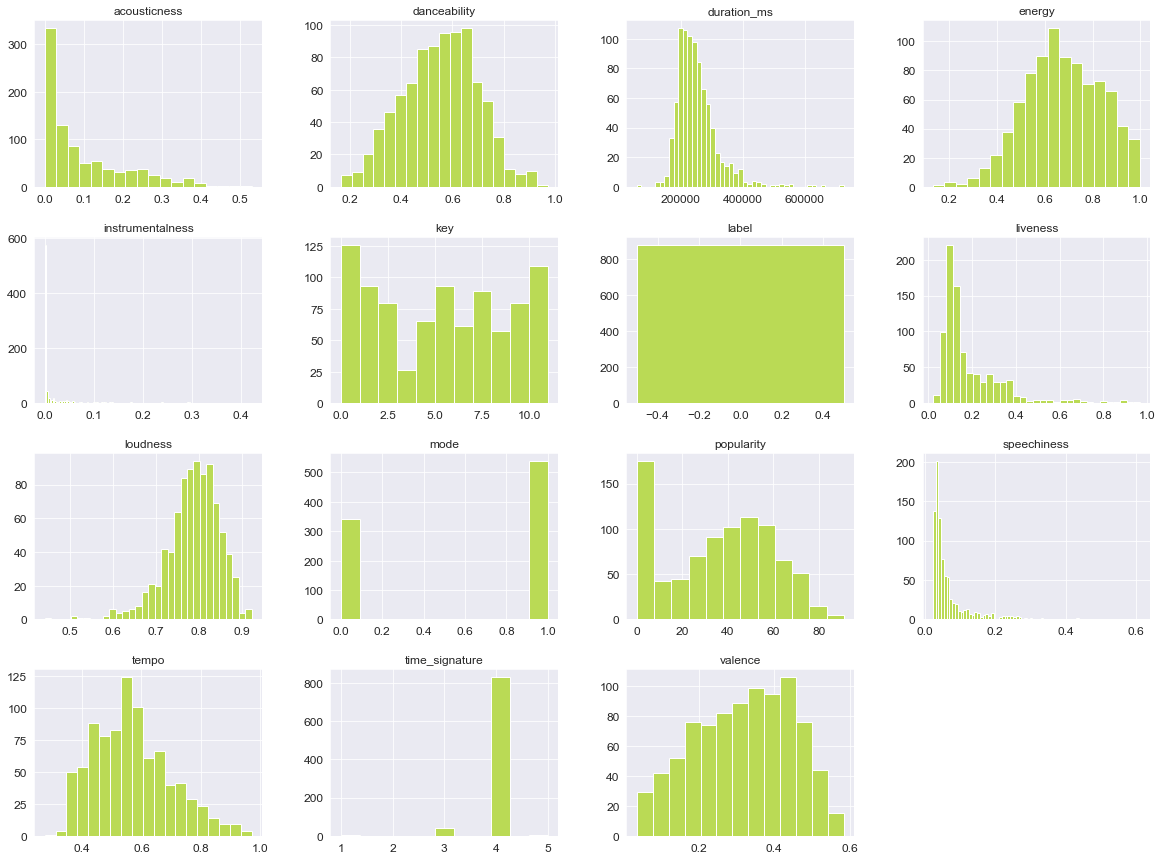

In [438]:
songs[songs['label']==0].hist(bins = 'auto', figsize=(20,15))

In [439]:
songs[songs['label']==1].head(40)

,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
2264,2017-01-14T10:37:43Z,Out Of My Control,HONNE,2RlZSOZkBlNWc4WgI8q4Bc,30,0.844,0.501,0.750065,0.0527,0.081200,0.620090,0.3610,0.576,0.015100,1,4,0,294747,1
1627,2017-12-31T07:57:29Z,Inside My Head (Bot Vs Riton Remix),Riton,26dbhQ8ZffJMcByxonlp8t,0,0.605,0.788,0.863156,0.3680,0.030900,0.777854,0.0320,0.674,0.000046,10,5,1,246190,1
2802,2013-11-09T23:10:32Z,The Ratcatcher,Antibalas,1vELnsC931YFGqLKBQne8C,0,0.679,0.819,0.768974,0.0481,0.134000,0.528091,0.1540,0.928,0.020900,11,4,0,492413,1
1634,2017-12-02T08:49:31Z,Sanctified,Nine Inch Nails,0hZpRFdaq34ykHEwvWbviP,43,0.711,0.476,0.547091,0.0337,0.113000,0.495305,0.1430,0.919,0.141000,9,4,1,348400,1
964,2019-03-23T04:16:16Z,Whatcha Gonna Do?,Pablo Cruise,6SMR0XI8a1D6gEpMTIju2y,46,0.736,0.530,0.592473,0.0331,0.049000,0.509951,0.1110,0.962,0.000015,0,4,1,256840,1
1123,2018-12-25T18:41:46Z,Money (feat. Nevve & Devante),Balt Getty,2iVMEqafoJmZNKNvtxr78W,17,0.739,0.790,0.811843,0.0435,0.044300,0.795970,0.0556,0.765,0.001850,8,4,1,214552,1
2247,2017-01-14T10:37:43Z,Run Up,Major Lazer,0SujigeT7cxuxBfhN3eOcp,6,0.803,0.743,0.871937,0.0681,0.105000,0.499789,0.0990,0.674,0.000002,1,4,0,203180,1
1909,2017-07-15T20:45:21Z,Lovely,Bohdi,1supSifxH5J9QUqkbObSMg,35,0.829,0.665,0.742320,0.0468,0.035100,0.453344,0.1280,0.905,0.000535,1,4,0,216833,1
1959,2017-06-30T16:00:33Z,Middle Child,Sallie Ford,3oB5zfWfP1YAapDZtoQjCL,7,0.763,0.796,0.841838,0.0368,0.374000,0.480345,0.1290,0.712,0.000032,2,4,1,138560,1
1933,2017-07-04T05:04:18Z,"10,000 Emerald Pools",BÃRNS,2pA4ip3VIEVcIa3qE02oAX,63,0.568,0.578,0.820468,0.0404,0.006940,0.647618,0.0990,0.555,0.000353,6,4,1,174693,1


In [440]:
songs[songs['label']==1].mean()

popularity              39.545970
danceability             0.679910
energy                   0.739695
loudness                 0.794404
speechiness              0.079674
acousticness             0.090511
tempo                    0.557794
liveness                 0.184172
valence                  0.712896
instrumentalness         0.029381
key                      5.442679
time_signature           3.987514
mode                     0.607264
duration_ms         238276.545970
label                    1.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E958A57E08>,
      dtype=object)

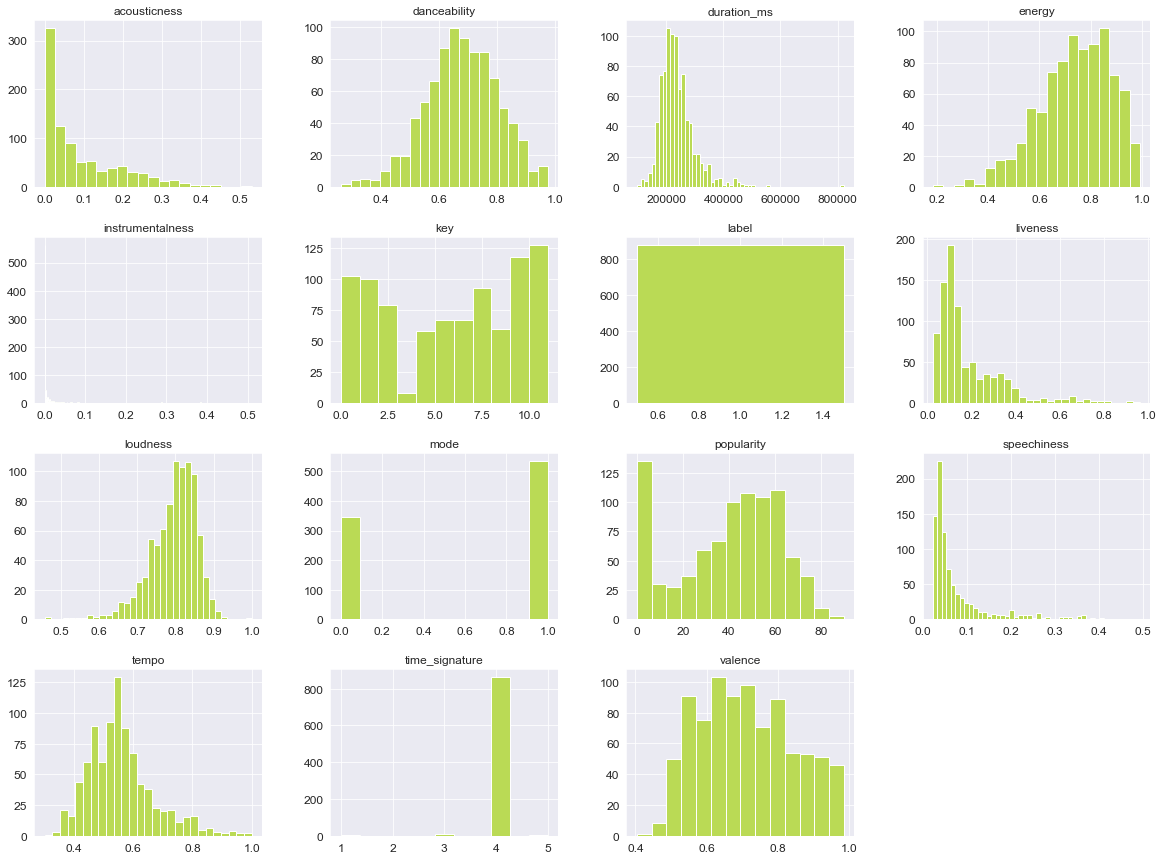

In [441]:
songs[songs['label']==1].hist(bins = 'auto', figsize=(20,15))

In [442]:
songs[songs['label']==2].head(40)

,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
1360,2018-06-03T16:57:56Z,J'veux du cuir,infinite bisous,5Oir22OhxkUuPGOul9hkXw,16,0.716,0.3290,0.622986,0.0461,0.739,0.559947,0.1030,0.4810,0.016900,11,4,0,242636,2
2351,2016-12-21T09:00:19Z,Always You,mAsis,0hueySgyEWeSq0o4MiduaA,24,0.377,0.5890,0.746620,0.1140,0.795,0.656003,0.1120,0.1760,0.001300,11,4,1,206655,2
2664,2016-09-09T23:13:33Z,You Are All I See,Active Child,5bhq35FYbYwGbO5PubhYPP,0,0.251,0.4300,0.730146,0.0328,0.517,0.596906,0.1330,0.0653,0.089500,4,4,0,245560,2
567,2019-09-29T18:48:35Z,Vienna,Billy Joel,4U45aEWtQhrm8A5mxPaFZ7,69,0.532,0.4950,0.792675,0.0343,0.659,0.578137,0.0754,0.3080,0.000000,10,4,1,214240,2
2010,2017-06-09T03:43:35Z,Dreams - Recorded at Spotify Studios NYC,LÃON,2q9jsX0poviVu9OSWgmRYg,53,0.421,0.2200,0.755893,0.0324,0.926,0.520294,0.1140,0.2340,0.000000,0,4,1,239347,2
859,2019-04-25T06:38:33Z,Glass House,Morgan Saint,0TLJ5UTC9a4Bh11jSP469H,43,0.694,0.3470,0.759701,0.0553,0.739,0.536809,0.1140,0.2180,0.000001,0,4,1,215347,2
1092,2019-01-03T06:57:28Z,Revelation (Vinyl Version),Troye Sivan,0aCwaqCDsEc9lRy6iU3WXl,30,0.175,0.0310,0.480469,0.0377,0.930,0.355510,0.1290,0.0407,0.001170,5,5,1,232148,2
151,2020-03-03T16:47:17Z,Sad Dream,Sky Ferreira,3hnlbzC6h0GxLfVmxAG4gA,44,0.674,0.4600,0.666062,0.0292,0.647,0.537054,0.1140,0.3140,0.000010,0,4,1,215867,2
484,2019-10-14T08:47:42Z,Still,BOOTS,3PWBsoxqQGkWj9VpGt0Zh6,15,0.277,0.2860,0.594882,0.0440,0.846,0.598553,0.2400,0.0708,0.005660,2,3,1,176507,2
628,2019-08-31T07:51:39Z,Angels,The xx,1zuKjpp4t7BS8JPKi6mkQr,65,0.424,0.1570,0.495338,0.0428,0.950,0.423584,0.1010,0.3420,0.059300,9,4,1,171653,2


In [443]:
songs[songs['label']==2].mean()

popularity              34.775956
danceability             0.478539
energy                   0.305486
loudness                 0.649457
speechiness              0.061121
acousticness             0.768888
tempo                    0.505736
liveness                 0.143482
valence                  0.255948
instrumentalness         0.031437
key                      5.128415
time_signature           3.734973
mode                     0.680328
duration_ms         243259.437158
label                    2.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9591B3E88>,
      dtype=object)

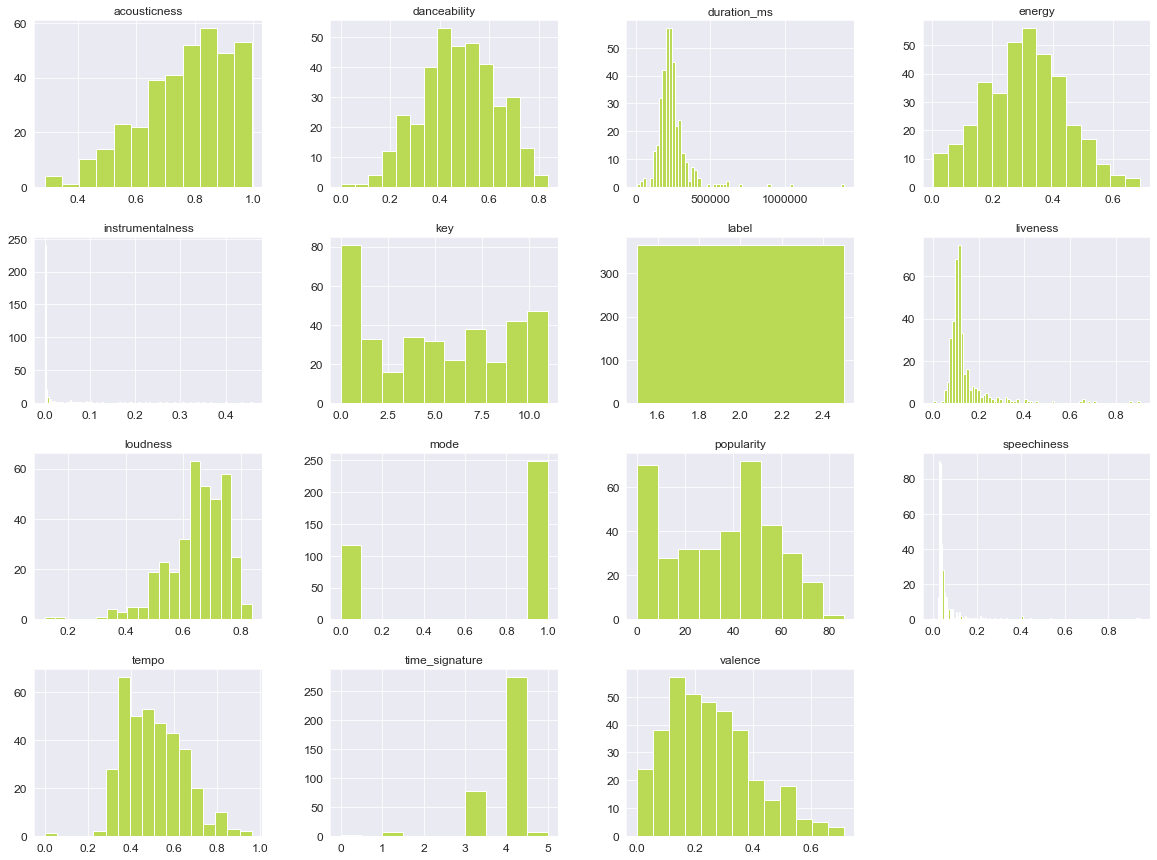

In [444]:
songs[songs['label']==2].hist(bins = 'auto', figsize=(20,15))

In [445]:
songs[songs['label']==3].head(40)

,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
2883,2015-06-08T17:46:09Z,Not Around,Montgomery,29BiilChpma8eMhwvyLlQn,0,0.652,0.769,0.770606,0.0313,0.261000,0.508984,0.1350,0.4780,0.561,1,4,0,208560,3
2308,2016-12-31T10:02:11Z,Change Is Inevitable - Original Mix,Dev Bhandari,2mQE6s7xpRKr8K62W7YGGG,0,0.808,0.690,0.663265,0.0749,0.000620,0.583149,0.0839,0.4490,0.837,10,4,0,373333,3
2776,2013-11-09T23:10:32Z,Heat Division,Dauwd,45bDwsLAz8UXEgW9mdDS9T,0,0.760,0.693,0.742579,0.0507,0.189000,0.587480,0.0902,0.0899,0.890,1,4,1,383104,3
156,2020-02-18T16:07:59Z,Wakin on a Pretty Day,Kurt Vile,3cSlU4ZH4wzb5pM7wI1k3f,58,0.379,0.782,0.753795,0.0358,0.047200,0.470604,0.2650,0.5490,0.748,11,4,1,570733,3
147,2020-03-03T16:47:17Z,Just Like Honey,The Jesus and Mary Chain,1LwP9g1Hjbs64jXM2Qsxry,61,0.341,0.552,0.693182,0.0423,0.000080,0.561594,0.0591,0.4860,0.616,8,4,1,182493,3
909,2019-04-13T21:50:25Z,Resist,FÃ©mina,0iVXHdpgn6ZtxYhm0cDR5A,19,0.813,0.618,0.712040,0.0833,0.484000,0.499780,0.0853,0.1560,0.438,0,4,1,267188,3
1801,2017-09-10T04:50:08Z,Seven Nation Army,The White Stripes,7i6r9KotUPQg3ozKKgEPIN,73,0.737,0.463,0.762472,0.0792,0.008170,0.573255,0.2550,0.3240,0.447,0,4,1,231733,3
736,2019-06-21T05:15:03Z,All My Friends,LCD Soundsystem,2Ud3deeqLAG988pfW0Kwcl,60,0.701,0.788,0.819898,0.0425,0.148000,0.659803,0.0977,0.7950,0.625,2,4,1,462267,3
311,2020-01-04T16:45:38Z,What's a Girl to Do,Fatima Yamaha,5N720bYInxSsiUDvBOLM3C,56,0.808,0.521,0.722245,0.1680,0.123000,0.555393,0.3360,0.7650,0.906,8,4,1,446510,3
2385,2016-12-21T09:00:19Z,Red Planet,Chip Wickham,0cO63BDjBjvLcVUn0b9Xg8,10,0.552,0.585,0.713205,0.0265,0.582000,0.485815,0.1070,0.4950,0.859,0,3,1,344400,3


In [446]:
songs[songs['label']==3].mean()

popularity              28.946619
danceability             0.612374
energy                   0.677103
loudness                 0.740141
speechiness              0.052848
acousticness             0.118562
tempo                    0.569572
liveness                 0.176661
valence                  0.470420
instrumentalness         0.724427
key                      5.238434
time_signature           3.935943
mode                     0.590747
duration_ms         298194.960854
label                    3.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E95CC4DFC8>,
      dtype=object)

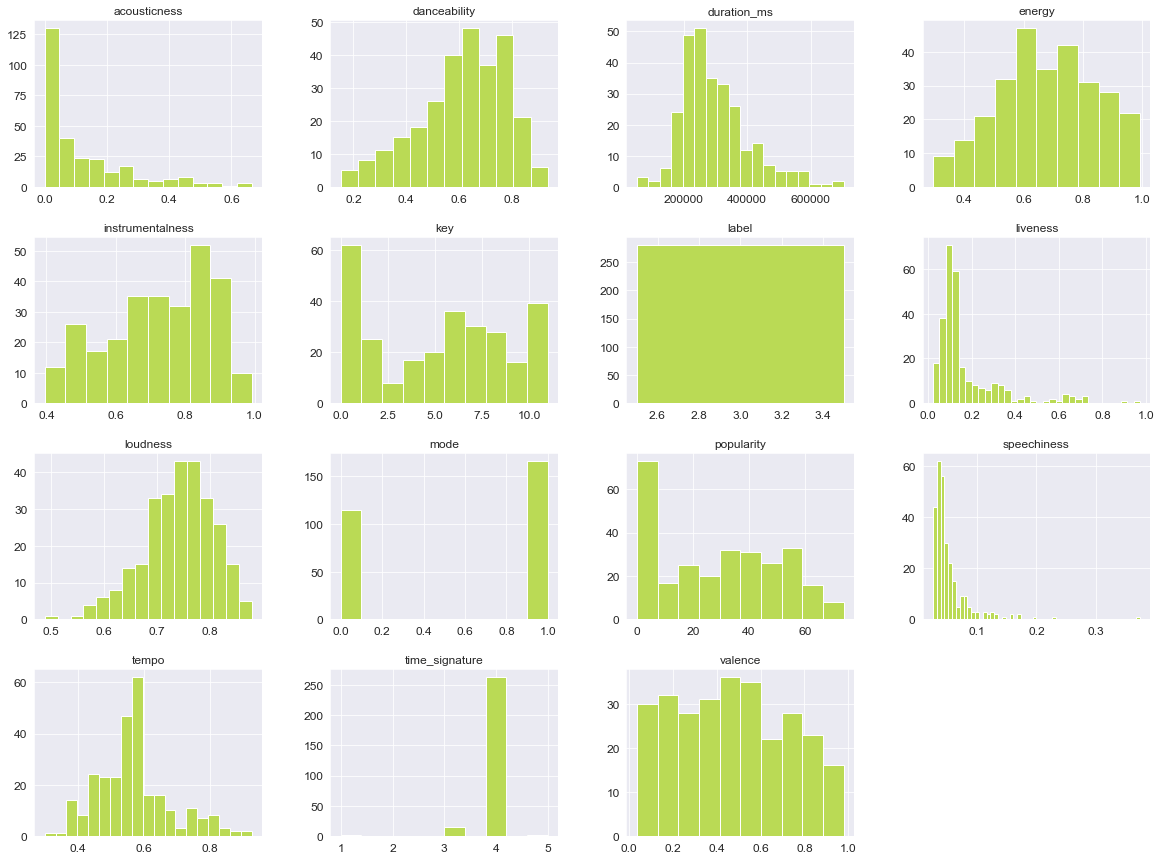

In [447]:
songs[songs['label']==3].hist(bins = 'auto', figsize=(20,15))

In [448]:
songs[songs['label']==4].head(40)

,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
436,2019-11-27T09:33:47Z,These Days,Molly Miller Trio,3tkXAdOrODstOhyxWz6RE7,3,0.4410,0.37600,0.557064,0.0366,0.690,0.801167,0.0982,0.3850,0.888,5,4,1,125120,4
1618,2017-12-31T07:57:29Z,Fanfare for the Common Man,Aaron Copland,3T9HSgS5jBFdXIBPav51gj,38,0.2280,0.17900,0.557867,0.0382,0.986,0.482663,0.0575,0.0378,0.954,10,4,1,196467,4
2718,2016-08-18T01:10:26Z,For Better or Worse,Henry Jackman,4eh4KH0cH06rgB3bXGHuWM,36,0.1460,0.02420,0.177459,0.0397,0.973,0.343219,0.0919,0.0319,0.673,4,4,0,124933,4
2670,2016-09-12T04:53:49Z,"FÃ¼r Elise, WoO 59",Ludwig van Beethoven,5yWClRIxwId7cl0WSboGUk,43,0.2960,0.07090,0.200668,0.0462,0.994,0.588086,0.0807,0.1920,0.892,9,3,0,188467,4
221,2020-01-23T01:24:23Z,Come Find Me,Emile Haynie,2KDmOXg95Jf5JXCwIhBRmk,39,0.2170,0.36400,0.789463,0.0314,0.872,0.348263,0.0961,0.0519,0.844,6,3,0,172867,4
439,2019-11-27T09:33:47Z,Versailles (Hold),Christian LÃ¶ffler,0k8uqvVH9RFNBxMi61cala,35,0.4070,0.32000,0.578563,0.0369,0.422,0.541460,0.1540,0.0630,0.691,0,4,0,283283,4
432,2019-11-27T09:33:47Z,Chifon Majesty,Norman A. Harris,6zcLoiHCckytUmgzmLegrU,1,0.7240,0.16700,0.358442,0.0312,0.721,0.507925,0.1110,0.1360,0.460,9,4,1,178067,4
1661,2017-12-02T08:49:31Z,Duel Of The Fates,London Voices,7di1zbwgfJkRLkTGV44icu,6,0.4400,0.43300,0.513159,0.0412,0.934,0.369975,0.2730,0.2160,0.811,2,4,0,254360,4
878,2019-04-13T21:50:25Z,Bassackwards,Kurt Vile,5f82Si6wLGgwidVnbIttPq,41,0.6290,0.57600,0.735248,0.0273,0.781,0.439697,0.1780,0.3990,0.710,7,4,1,586133,4
29,2019-10-23T17:09:03Z,"Clair de Lune, L. 32",Claude Debussy,5u5aVJKjSMJr4zesMPz7bL,64,0.3350,0.00532,0.145521,0.0376,0.994,0.304635,0.0621,0.0397,0.912,1,4,1,268000,4


In [449]:
songs[songs['label']==4].mean()

popularity              31.200000
danceability             0.420509
energy                   0.286974
loudness                 0.534924
speechiness              0.051977
acousticness             0.791600
tempo                    0.515916
liveness                 0.147980
valence                  0.211970
instrumentalness         0.813374
key                      5.573913
time_signature           3.756522
mode                     0.582609
duration_ms         277015.904348
label                    4.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E94B4ECE88>,
      dtype=object)

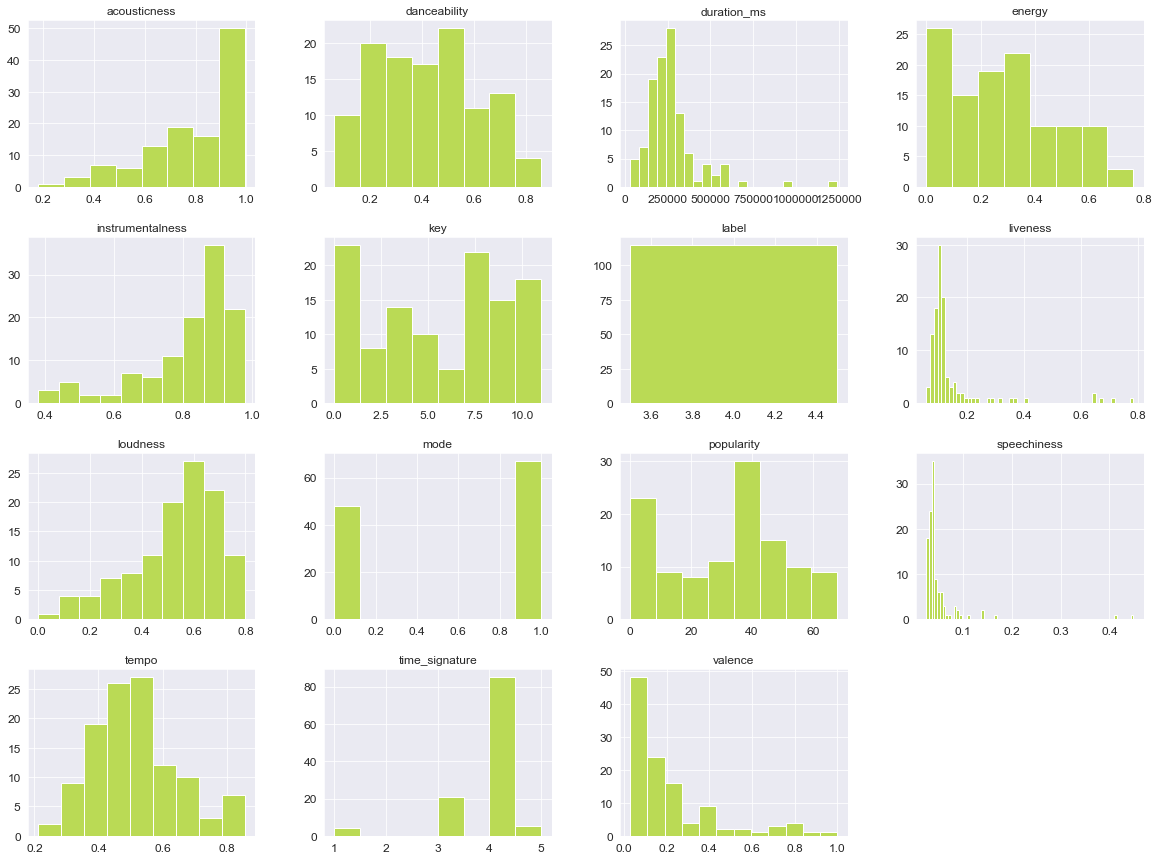

In [450]:
songs[songs['label']==4].hist(bins = 'auto', figsize=(20,15))

In [451]:
songs[songs['label']==5].head(40)

,added_at,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
346,2020-01-04T16:45:38Z,Higher Self,Karmic,6zqFFx07Ua8DewOxLgcmY3,41,0.845,0.688,0.806688,0.0528,0.386,0.550705,0.2160,0.750,0.010400,6,4,0,225449,5
2418,2016-12-04T05:09:37Z,Bae,Mura Masa,3VHNY2kK1sorl8HfJtc1zG,0,0.763,0.522,0.737554,0.1840,0.599,0.625097,0.1100,0.322,0.002760,0,4,0,144000,5
2734,2016-08-18T01:10:26Z,Blue,MARINA,5deoPfYU3gEtcIxPgap4Gz,48,0.765,0.767,0.754779,0.0301,0.374,0.557230,0.0949,0.552,0.000020,0,4,1,254147,5
787,2019-05-31T09:10:42Z,I Remember - Live From Spotify House SXSW '16,AlunaGeorge,2BnUHxd9RFqidAVm6YEmIy,10,0.579,0.534,0.742242,0.0334,0.503,0.620108,0.1830,0.393,0.000021,8,4,1,264240,5
1624,2017-12-31T07:57:29Z,Equestrian,Omni,4cwchR9vVILHjHb2Xga4m5,35,0.635,0.748,0.851733,0.0342,0.498,0.722449,0.2320,0.969,0.011900,4,4,1,160469,5
188,2020-02-18T16:07:59Z,Motion Sickness,Phoebe Bridgers,6LxcPUqx6noURdA5qc4BAT,66,0.652,0.545,0.731570,0.0358,0.774,0.495227,0.0847,0.626,0.042800,1,4,1,229760,5
150,2020-03-03T16:47:17Z,Goodmorning,Bleachers,1K13OsIMc0HLgEJHZoWH78,58,0.650,0.448,0.718282,0.0929,0.577,0.370146,0.1310,0.511,0.000000,2,4,1,193413,5
1060,2019-02-03T11:56:36Z,Stranger in Moscow,Michael Jackson,64KrFHj9p5AyCX2yZQr4YJ,56,0.802,0.468,0.741724,0.0378,0.248,0.601279,0.3200,0.586,0.000600,1,4,1,343960,5
699,2019-06-25T07:09:49Z,Part of Me,Tedeschi Trucks Band,53DRkI3ebM3SbSQm4gQ1vF,53,0.679,0.608,0.749365,0.0340,0.434,0.517365,0.0942,0.735,0.000013,7,4,1,246573,5
2246,2017-01-14T10:37:43Z,Lil Baby,Mustard,4EBR01Mp4tjpKMYjKNpj2f,53,0.657,0.480,0.730586,0.0519,0.359,0.462946,0.4970,0.315,0.000000,2,4,1,259413,5


In [452]:
songs[songs['label']==5].mean()

popularity              35.927361
danceability             0.647194
energy                   0.540324
loudness                 0.735330
speechiness              0.096471
acousticness             0.535034
tempo                    0.536842
liveness                 0.192902
valence                  0.581542
instrumentalness         0.033767
key                      5.075061
time_signature           3.961259
mode                     0.658596
duration_ms         221826.699758
label                    5.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E94B1C3D08>,
      dtype=object)

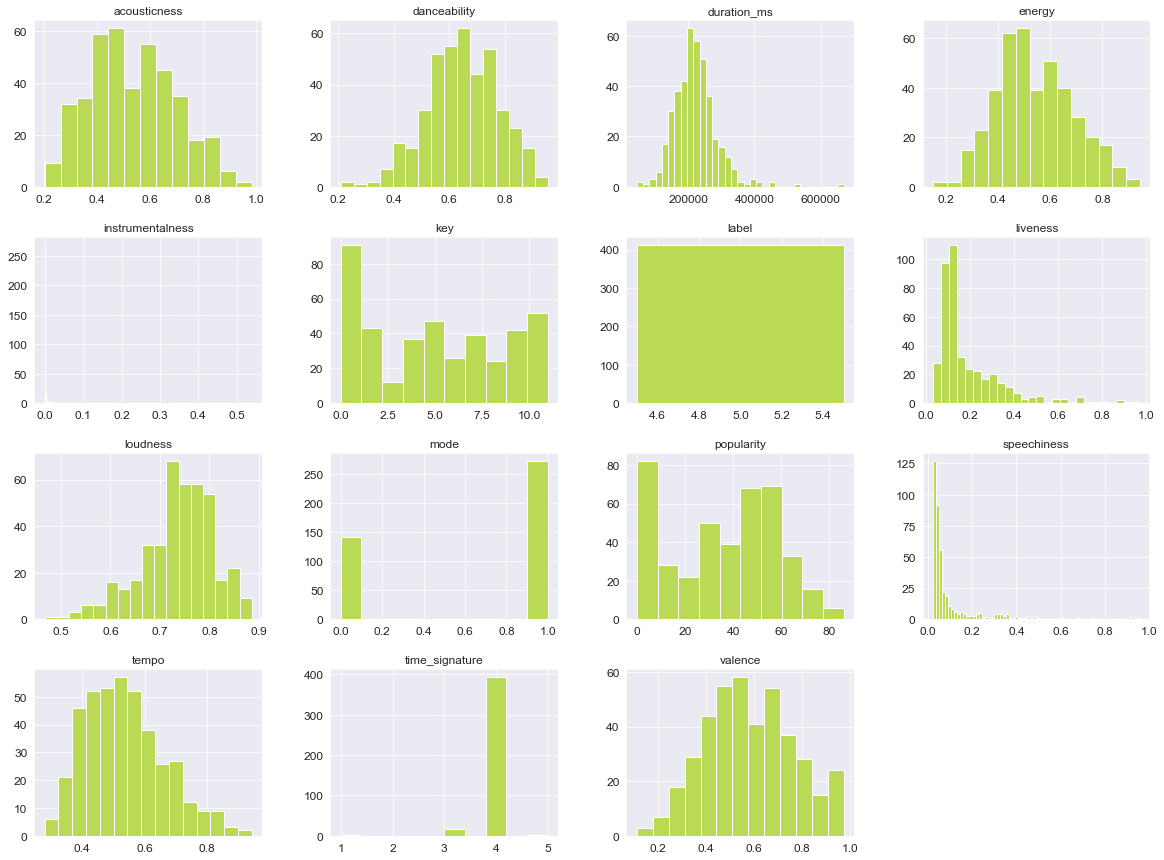

In [453]:
songs[songs['label']==5].hist(bins = 'auto', figsize=(20,15))

# Confusion Matrices and Supervised Machine Learning
We've completed our exploration. Now let's print out some confusion matrics and use some supervised machine learning techniques to test how accurate each method is with predicting the label that should be assigned to any given song from the K-Means clustering technique we used earlier.<br>
<br>
Below we will split our data into a training set and a test set. This is a cornerstone step in practical data analysis and is a good habit to retain. For this dataset, we will train 2/3's of our data, and then test the other 1/3 to see how accurate different kinds of supervised machine learning techniques are at predicting the label that our test songs should be labeled.<br>
<br>
We will run our test set against the following supervised machine learning methods:
- Random Forest
- K-Nearest Neighbor (KNN)
- Multi-layer Perceptron classifier (MLP Classifier)
- Suppert Vector Machine (SVM)

# Random Forest (RF)

In [454]:
X = songs_features
y = y_kmeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [455]:
# Predicting the Test set results
y_pred = rfc.predict(X_test)

In [456]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[301   5   0   1   0   3]
 [  6 248   0   0   0   5]
 [  0   0 110   0   1   4]
 [  0   2   0  91   0   0]
 [  0   0   0   1  42   0]
 [  2   4  13   0   0 130]]


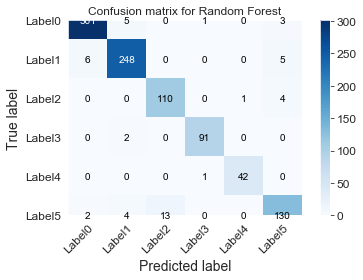

In [457]:
# Confusion matrix
definitions = ['Label0','Label1','Label2','Label3','Label4','Label5']

plot_confusion_matrix(y_test, y_pred, classes=definitions,
                      title='Confusion matrix for Random Forest')

Random Forest has a neat "feature importance" function. We can use this to see the most important value across all songs in our dataset for each song feature.

In [458]:
# View a list of the features and their importance scores
features = songs_features.columns
list(zip(songs_features[features], rfc.feature_importances_))

[('danceability', 0.0534358323803732),
 ('energy', 0.09629685617400648),
 ('loudness', 0.044977578209626064),
 ('speechiness', 0.0149642695316257),
 ('acousticness', 0.2553407914878941),
 ('tempo', 0.018886669007994985),
 ('liveness', 0.01468200548117958),
 ('valence', 0.302899378873883),
 ('instrumentalness', 0.19851661885341693)]

# K-Nearest Neighbor (KNN)

In [459]:
knn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [460]:
knn_pred = knn.predict(X_test)

Confusion matrix, without normalization
[[287  15   2   4   0   2]
 [ 15 240   0   0   0   4]
 [  4   0 108   0   0   3]
 [  2   4   0  87   0   0]
 [  0   0   2   4  37   0]
 [  7   6   8   0   0 128]]


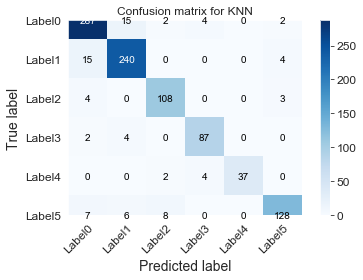

In [461]:
plot_confusion_matrix(y_test, knn_pred, classes=definitions,
                      title='Confusion matrix for KNN')

# Support Vector Machines (SVM)

In [462]:
#Create a svm Classifier
svm = svm.SVC(kernel="linear") 

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)

Confusion matrix, without normalization
[[305   2   0   1   0   2]
 [  1 258   0   0   0   0]
 [  0   0 111   0   1   3]
 [  1   2   0  90   0   0]
 [  0   0   4   0  39   0]
 [  2   8   3   0   0 136]]


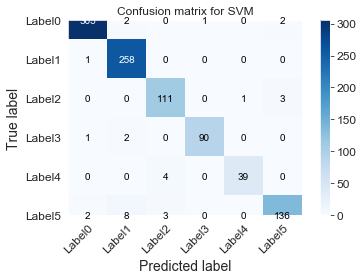

In [463]:
plot_confusion_matrix(y_test, svm_pred, classes=definitions,
                      title='Confusion matrix for SVM')

# Multi-layer Perceptron classifier (MLP Classifier)

In [464]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

C:\Users\My Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [465]:
mlp_pred = mlp.predict(X_test)

Confusion matrix, without normalization
[[305   4   0   0   0   1]
 [  1 257   0   0   0   1]
 [  0   0 113   0   1   1]
 [  0   2   0  90   1   0]
 [  0   0   3   0  40   0]
 [  0   1   3   0   0 145]]


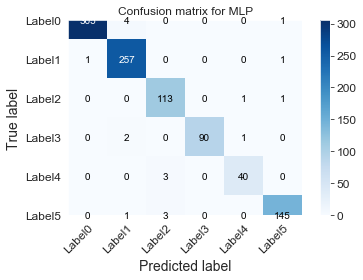

In [466]:
plot_confusion_matrix(y_test, mlp_pred, classes=definitions,
                      title='Confusion matrix for MLP')

# Conclusion
Below we can see a printout of classification reports for the four machine learning models that we used in our analysis. Bearing in mind that the K-Means method of choice for clustering, we can see that SVM and MLP returned the highest precision, recall, and f1 averages when making predictions against our test data.

In [467]:
print(classification_report(y_test,y_pred,target_names=definitions)+'forest')

              precision    recall  f1-score   support

      Label0       0.97      0.97      0.97       310
      Label1       0.96      0.96      0.96       259
      Label2       0.89      0.96      0.92       115
      Label3       0.98      0.98      0.98        93
      Label4       0.98      0.98      0.98        43
      Label5       0.92      0.87      0.89       149

    accuracy                           0.95       969
   macro avg       0.95      0.95      0.95       969
weighted avg       0.95      0.95      0.95       969
forest


In [468]:
print(classification_report(y_test,knn_pred,target_names=definitions)+'KNN')

              precision    recall  f1-score   support

      Label0       0.91      0.93      0.92       310
      Label1       0.91      0.93      0.92       259
      Label2       0.90      0.94      0.92       115
      Label3       0.92      0.94      0.93        93
      Label4       1.00      0.86      0.92        43
      Label5       0.93      0.86      0.90       149

    accuracy                           0.92       969
   macro avg       0.93      0.91      0.92       969
weighted avg       0.92      0.92      0.92       969
KNN


In [469]:
print(classification_report(y_test,svm_pred,target_names=definitions)+'SVM')

              precision    recall  f1-score   support

      Label0       0.99      0.98      0.99       310
      Label1       0.96      1.00      0.98       259
      Label2       0.94      0.97      0.95       115
      Label3       0.99      0.97      0.98        93
      Label4       0.97      0.91      0.94        43
      Label5       0.96      0.91      0.94       149

    accuracy                           0.97       969
   macro avg       0.97      0.96      0.96       969
weighted avg       0.97      0.97      0.97       969
SVM


In [470]:
print(classification_report(y_test,mlp_pred,target_names=definitions)+'MLP')

              precision    recall  f1-score   support

      Label0       1.00      0.98      0.99       310
      Label1       0.97      0.99      0.98       259
      Label2       0.95      0.98      0.97       115
      Label3       1.00      0.97      0.98        93
      Label4       0.95      0.93      0.94        43
      Label5       0.98      0.97      0.98       149

    accuracy                           0.98       969
   macro avg       0.98      0.97      0.97       969
weighted avg       0.98      0.98      0.98       969
MLP
